In [ ]:
import cv2
import matplotlib.pyplot as mpl
import numpy as np
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from sklearn.metrics import f1_score
import tensorflow as tf

In [ ]:
def read_image(path):
  photo = cv2.imread(path)
  photo = cv2.cvtColor(photo, cv2.COLOR_BGR2RGB)
  return photo


read_image("/content/drive/MyDrive/data/download (2).jpg")


array([[[148, 119,  53],
        [194, 167, 100],
        [216, 195, 128],
        ...,
        [ 84,  76,  55],
        [ 39,  31,  12],
        [ 41,  32,  15]],

       [[151, 109,  49],
        [192, 154,  92],
        [219, 185, 122],
        ...,
        [ 80,  72,  53],
        [ 95,  87,  68],
        [113, 104,  89]],

       [[144,  78,  28],
        [157,  95,  44],
        [173, 117,  66],
        ...,
        [129, 120, 103],
        [108,  99,  82],
        [101,  92,  77]],

       ...,

       [[ 37,  31,  31],
        [ 38,  32,  32],
        [ 40,  34,  34],
        ...,
        [ 38,  37,  35],
        [ 31,  30,  28],
        [ 32,  31,  29]],

       [[ 35,  29,  29],
        [ 35,  31,  30],
        [ 38,  32,  32],
        ...,
        [ 31,  30,  28],
        [ 27,  26,  24],
        [ 32,  31,  29]],

       [[ 30,  26,  25],
        [ 27,  26,  24],
        [ 29,  25,  24],
        ...,
        [ 31,  30,  28],
        [ 33,  32,  30],
        [ 33,  32,  30]]

In [ ]:
def read_image_gray(path):
  photo = cv2.imread(path)
  gray = cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY)
  return gray


In [ ]:
model_plate = cv2.CascadeClassifier("/content/drive/MyDrive/data/haarcascade_russian_plate_number.xml")

In [ ]:
def plate_detector(path, size=0.5):
    img = read_image(path)
    plate = model_plate.detectMultiScale(img, 1.1, 4)
    for (x,y,w,h) in plate:
        p = int(0.06*img.shape[0])
        d = int(0.025*img.shape[1])
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,255),5)
        plate_cropped = img[y+d:y+h-d, x+p:x+w-d]

    return img, plate_cropped



In [ ]:
photo_out, plate_ = plate_detector("/content/drive/MyDrive/data/maxresdefault.jpg")

In [ ]:
def show_image(img):
    mpl.imshow(img)

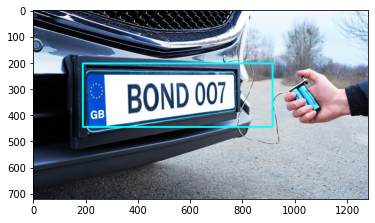

In [ ]:
show_image(photo_out)

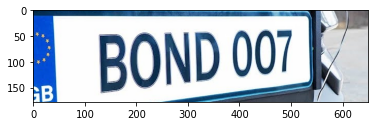

In [ ]:
show_image(plate_)

In [ ]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            mpl.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0
            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    mpl.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [ ]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    mpl.imshow(img_binary_lp, cmap='gray')
    mpl.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

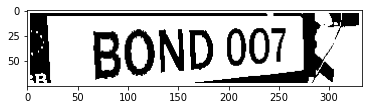

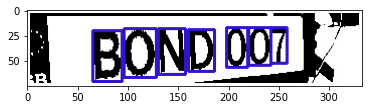

In [ ]:
char = segment_characters(plate_)

IndexError: ignored

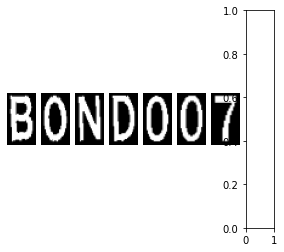

In [ ]:
for i in range(10):
    mpl.subplot(1, 10, i+1)
    mpl.imshow(char[i], cmap='gray')
    mpl.axis('off')

In [ ]:
def f1score(y, y_pred):
  return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro') 

def custom_f1score(y, y_pred):
  return tf.py_function(f1score, (y, y_pred), tf.double)

In [ ]:
#keras.backend.clear_session()
model = Sequential()

In [ ]:
model.add(Convolution2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Convolution2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Convolution2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Convolution2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        23248     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        131104    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        131136    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        65600     
Total params: 351,088
Trainable params: 351,088
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.add(layer=MaxPooling2D(pool_size=(2,2)))

In [ ]:
model.add(Dropout(rate=0.4))

In [ ]:
model.add(layer=Flatten())

In [ ]:
model.add(layer=Dense(units=128, activation="relu"))

In [ ]:
model.add(layer=Dense(units=36, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        23248     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        131104    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        131136    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        65600     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [ ]:
from keras.models import load_model
model = load_model("/content/drive/MyDrive/data/model5_org.h5", custom_objects={"custom_f1score": custom_f1score})

In [ ]:
model.compile(optimizer=optimizers.Adam(0.0001), loss="sparse_categorical_crossentropy", metrics=[custom_f1score])

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = "/content/drive/MyDrive/data/data"
train_generator = train_datagen.flow_from_directory(
        path+"/train",  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        class_mode="sparse",batch_size=1)

validation_generator = train_datagen.flow_from_directory(
        path+"/val",  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
        class_mode="sparse", batch_size=1)


Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [ ]:
import keras.callbacks
class stop_training_callback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get("val_custom_f1score") > 0.997):
      self.model.stop_training = True

  def on_epoch_end(self, batch, logs={}, ):
        self.model.save("/content/drive/MyDrive/data/model_5neworg.h5")

In [ ]:
batch_size = 1
callbacks = [stop_training_callback()]
model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator,
      validation_steps = validation_generator.samples // batch_size,
      epochs = 80, verbose=1, callbacks=callbacks)

Epoch 1/80
864/864 [==============================] - 264s 296ms/step - loss: 0.0867 - custom_f1score: 0.9786 - val_loss: 0.0521 - val_custom_f1score: 0.9815
Epoch 2/80
864/864 [==============================] - 10s 11ms/step - loss: 0.0749 - custom_f1score: 0.9754 - val_loss: 0.0624 - val_custom_f1score: 0.9722
Epoch 3/80
864/864 [==============================] - 10s 11ms/step - loss: 0.0820 - custom_f1score: 0.9661 - val_loss: 0.0815 - val_custom_f1score: 0.9676
Epoch 4/80
864/864 [==============================] - 10s 12ms/step - loss: 0.0676 - custom_f1score: 0.9802 - val_loss: 0.0350 - val_custom_f1score: 0.9954
Epoch 5/80
864/864 [==============================] - 10s 12ms/step - loss: 0.0658 - custom_f1score: 0.9790 - val_loss: 0.0388 - val_custom_f1score: 0.9861
Epoch 6/80
864/864 [==============================] - 10s 11ms/step - loss: 0.0804 - custom_f1score: 0.9633 - val_loss: 0.0561 - val_custom_f1score: 0.9769
Epoch 7/80
864/864 [==============================] - 10s 12ms

In [ ]:
model.save("/content/drive/MyDrive/data/model_5testneworg.h5")

In [ ]:

l1 = model.history.history["loss"]

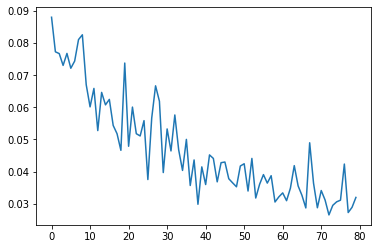

In [ ]:
mpl.plot(l1)

In [ ]:
la = model.history.history["custom_f1score"]

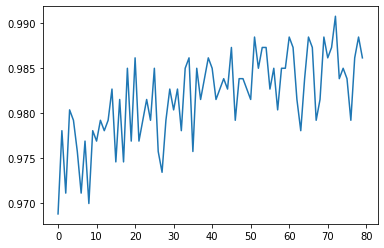

In [ ]:
mpl.plot(la)

In [ ]:
lv2 = model.history.history["val_loss"]

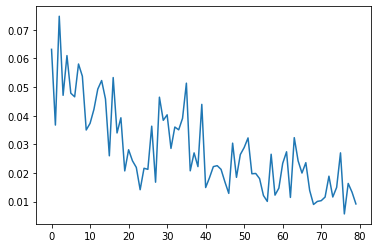

In [ ]:
mpl.plot(lv2)

In [ ]:
lva = model.history.history["val_custom_f1score"]

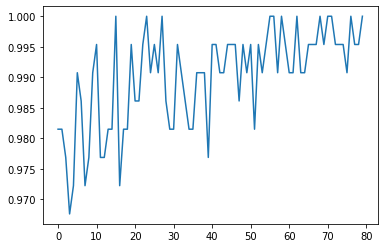

In [ ]:
mpl.plot(lva)

In [ ]:
# Predicting the output
def fix_dimension(img): 
  new_img = np.zeros((28,28,3))
  for i in range(1):
    new_img[:,:,i] = img
  return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1, 28,28,3) #preparing image for the model
        y_ = np.argmax(model.predict(img, batch_size=1)[0], axis=-1) #predicting the class
        character = dic[y_] #
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results())

B0ND007


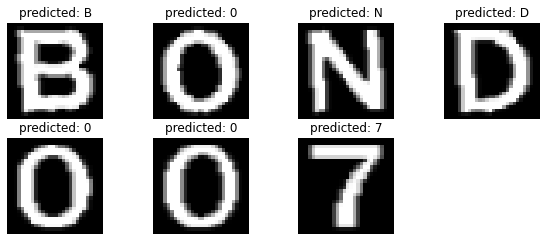

In [ ]:
# Segmented characters and their predicted value.
mpl.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    mpl.subplot(3,4,i+1)
    mpl.imshow(img,cmap='gray')
    mpl.title(f'predicted: {show_results()[i]}')
    mpl.axis('off')
mpl.show()

2352